<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Otimiza%C3%A7%C3%A3o_Ag_pol%C3%ADtica_de_manuten%C3%A7%C3%A3o_preventiva_imperfeita_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [487]:
%%capture
pip install geneticalgorithm

In [488]:
%%capture
pip install memory-profiler

In [489]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import csv
import math
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import differential_evolution
from memory_profiler import profile
import locale

In [490]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [491]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [492]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [493]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [494]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 17000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 1460 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 17000 # Valor para o custo da manutenção corretiva
CMP = 4000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = 'ag'

# Configuraçaõ dos cerarios utulidados para os testes: primeiro_cenario, segundo_cenario, terceiro_cenario, quarto_cenario
CENARIO = 'terceiro_cenario'

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/Resultados_{CENARIO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_{CENARIO}'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'
NOME_ARQUIVO_PARAMETROS = 'parametros'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO_TESTE = f'{CENARIO}'

In [495]:
print(LINK_ARQUIVO_PRINCIPAL)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/Resultados_terceiro_cenario/


In [496]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha $\it{u(t)}$")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [497]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [498]:
# efine a função de melhoria Linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j]*theta)
        fator.append(linha)

    return fator

In [499]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [500]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j]**theta)
        fator.append(linha)

    return fator

In [501]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [502]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [503]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {1.0: 4000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.1 or si > 1.0 else np.interp(si, [1.0], [4000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US
17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US 2.000 e US
3.000, respectivamente e MC fixa em US$15.000 texto em itálico

In [504]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/{CENARIO_TESTE}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,0.7,182
1,1309,1,7,0,0.7,366
2,1778,1,7,0,0.7,547
3,0,1,0,0,0.7,731
4,0,0,0,0,1.0,912


* t: Representa os tempos de falha.
* k: Indica o índice do sistema.
* c: Representa o número de ciclos de manutenção.
* n: Indica o número de falhas em cada ciclo de manutenção preventiva.
* s: Representa a severidade das manutenções preventivas em cada sistema.
* T: Indica os tempos das manutenções preventivas.

In [505]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [506]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [507]:
# Ajusta o modelo com base nos dados lidos
def adjust_model():
    global model_adjusted
    model_adjusted = True

    varbound = np.array([[100, 150], [3, 5], [0, 1]])

    algorithm_param = {
        'max_num_iteration': 50,
        'population_size': 100,
        'mutation_probability': 0.05,
        'elit_ratio': 0.01,
        'crossover_probability': 0.75,
        'parents_portion': 0.3,
        'crossover_type': 'two_point',
        'max_iteration_without_improv': None
    }

    model = ga(
        function=objective,
        dimension=3,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_param,
        convergence_curve=False,
        progress_bar=False
    )

    # Registre o tempo de início de convergência para a primeira etapa
    start_time_first_stage = time.time()

    model.run()


    # Registre o tempo de término
    end_time_first_stage = time.time()

    # Calcule o tempo total de convergência
    convergence_time_first_stage = end_time_first_stage - start_time_first_stage

    res = model.best_variable

    lamb = res[0]
    beta = res[1]
    theta = res[2]

    return lamb, beta, theta, convergence_time_first_stage

In [508]:
# Variáveis Globais
model_adjusted = False

In [509]:
# Ajusta o modelo
lamb, beta, theta, convergence_time_first_stage = adjust_model()
print(f'lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

 The best solution found:
 [149.89054554   3.13782851   0.92253851]

 Objective function:
 -5.556983980606276e-06
lamb: 149.8905455446102
beta: 3.1378285095144935
theta: 0.9225385133304281

Tempo de Convergência para a primeira etapa: 0.9974362850189209 segundos


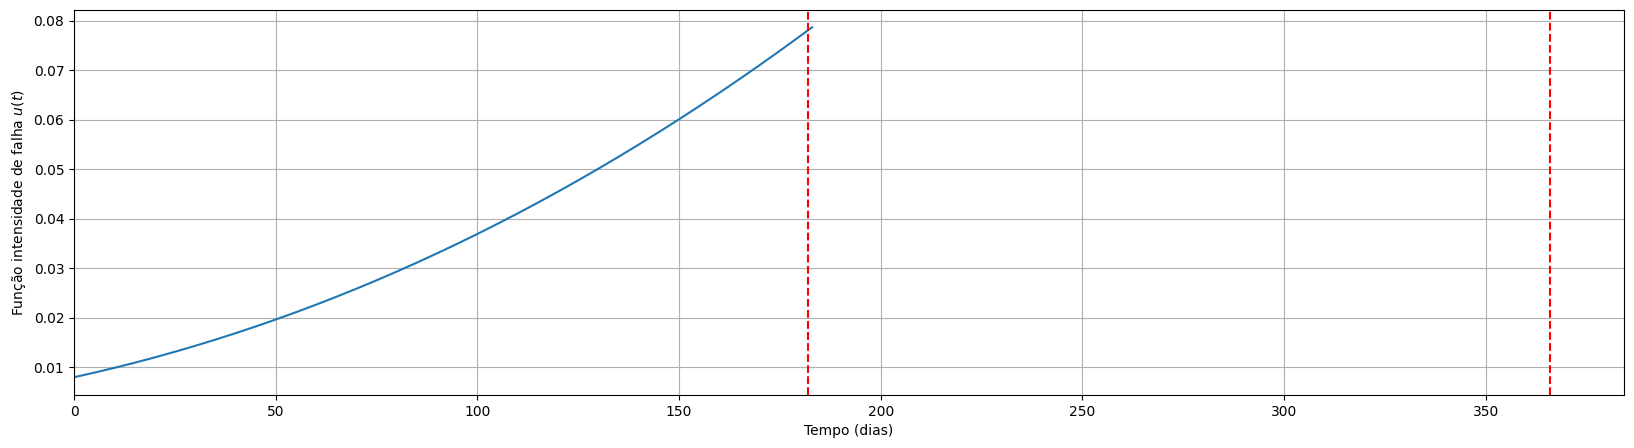

Fator ajuste:  [0.47574494103186826, 0.47574494103186826, 0.47574494103186826, 0.47574494103186826, 0.602491321861236, 0.47574494103186826, 0.47574494103186826]


In [510]:
# lamb = 149.46611911427442
# beta = 3.7082881597847184
# theta = 0.8860147939929904

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [511]:
# Nome do arquivo CSV para salvar os resultados dos parametros
nome_arquivo_parametros = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PARAMETROS}.csv'
print(nome_arquivo_parametros)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/Resultados_terceiro_cenario/parametros.csv


In [512]:
# # Gravar os valores de Lambda, Beta e Theta em um arquivo separado
# melhores_parametros = []

# try:
#     with open(nome_arquivo_parametros, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_parametros.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução


# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_parametros), lamb, beta, theta, convergence_time_first_stage]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo_parametros, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [513]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo_parametros, sep=",")
resultado.head(10)

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
0,0,148.306617,3.000818,0.986152,1.001397
1,1,149.629126,3.079367,0.891548,1.035301
2,2,149.902273,3.138765,0.974574,0.924227
3,3,148.962060,3.000829,0.888612,1.096426
4,4,149.949683,3.125860,0.902644,0.990505
5,5,149.442889,3.085611,0.984028,0.997733
6,6,145.794318,3.021067,0.960505,0.980527
7,7,149.945273,3.015578,0.981536,1.005521
8,8,146.866620,3.013238,0.991170,0.994863
9,9,149.890546,3.137829,0.922539,0.997436


In [514]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
count,10.00000,10.000000,10.000000,10.000000,10.000000
mean,4.50000,148.868940,3.061896,0.948331,1.002394
std,3.02765,1.458032,0.057997,0.042193,0.043164
min,0.00000,145.794318,3.000818,0.888612,0.924227
25%,2.25000,148.470478,3.013823,0.907618,0.991595
50%,4.50000,149.536007,3.050217,0.967539,0.997585
75%,6.75000,149.899341,3.115797,0.983405,1.004490
max,9.00000,149.949683,3.138765,0.991170,1.096426


In [515]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']

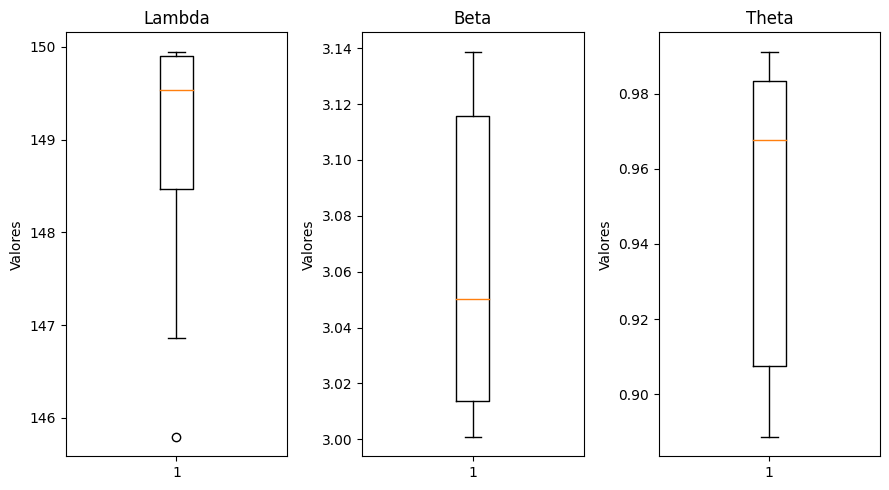

In [516]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

# Etapa 2: Otimização

In [517]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [518]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]

def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:1.0, 3:1.0, 5:1.0, 7:1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo

    global s
    T = [0]
    s_row = []
    cont = 0

    for number in x:
        modulo = int(number) % 2
        if modulo == 1:
            inteiro = int(number)
            s_row.append(dict_severidades[inteiro])  # Severidade
            frac = number - inteiro  # Tempo
            t = (cont + frac) * 30
            T.append(int(t))
        cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
    #
    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))
    #
    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)
    #
    # Retorna o custo
    return np.array(results)

Aplica AG para determinar tempos e severidades

In [519]:
# Otimização da política de manutenção com AG
dimension = 24
varbound = np.array([[0, 8]] * 24)

algorithm_param_ = {
    'max_num_iteration': 100,\
    'population_size': 100,\
    'mutation_probability': 0.05,\
    'elit_ratio': 0.01,\
    'crossover_probability': 0.75,\
    'parents_portion': 0.3,\
    'crossover_type': 'two_point',\
    'max_iteration_without_improv': None
}

model_=ga(
    function = objective_st,
    dimension = dimension,
    variable_type = 'real',
    variable_boundaries = varbound,
    algorithm_parameters = algorithm_param_
)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

model_.run()

# Registre o tempo de término
end_time_second_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

In [520]:
convergence = model_.report # número total de interações
solution = model_.output_dict['function'] # Melhor Custo
print(convergence)
print(solution)

[3701.715515962289, 3701.715515962289, 3459.678609867994, 3075.2136274092286, 3075.2136274092286, 2870.318601996787, 2657.640191035445, 2657.640191035445, 2473.063500651575, 2473.063500651575, 2473.063500651575, 2473.063500651575, 2473.063500651575, 2473.063500651575, 2473.063500651575, 2473.063500651575, 2463.1415913441724, 2433.5675709424145, 2433.5675709424145, 2433.5675709424145, 2430.9870255381015, 2430.9870255381015, 2430.9870255381015, 2430.9870255381015, 2429.600748566144, 2429.600748566144, 2429.600748566144, 2429.600748566144, 2429.600748566144, 2429.600748566144, 2429.5369751286153, 2429.5369751286153, 2429.5369751286153, 2429.5369751286153, 2429.5369751286153, 2429.5369751286153, 2429.5369751286153, 2429.5369751286153, 2429.5369751286153, 2429.5369751286153, 2427.320554120709, 2427.320554120709, 2427.320554120709, 2427.320554120709, 2427.320554120709, 2427.320554120709, 2423.213683100493, 2423.213683100493, 2423.213683100493, 2423.213683100493, 2423.213683100493, 2423.21368

In [521]:
# Retorna o número de interações necessárias para chegar ao melhor custo.
def numero_interacoes(convergence):
  for i, custo in enumerate(convergence):
    if custo == min(convergence):
      return i + 1

numero_interacoes = numero_interacoes(convergence)
print(numero_interacoes)

97


In [522]:
melhorCusto = format_currency(model_.output_dict['function'])
print(melhorCusto)

R$ 2.419,67


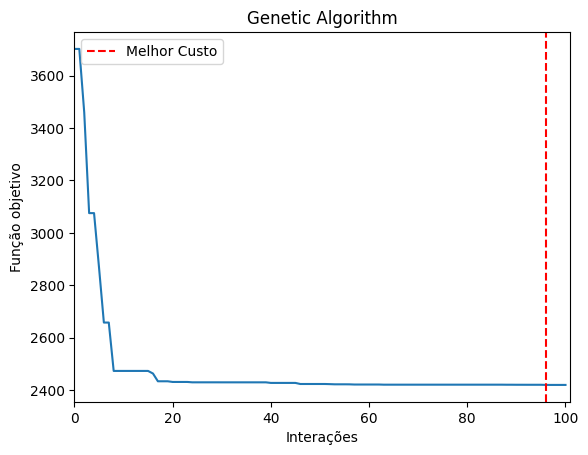


Cenário: terceiro_cenario
Número total de iterações: 100
Tamanho da população: 100
Número de Dimensões: 24
Melhor Custo: R$ 2.419,67
Número de Iterações até o Melhor Custo: 97
Tempo de Convergência para a segunda etapa: 77.98457169532776 segundos


In [523]:
# Plotando a curva de convergência
plt.figure()
plt.plot(convergence)

# Localizando o índice da melhor interação
index_melhor_custo = convergence.index(min(convergence))

# Plotando a linha vertical
plt.axvline(index_melhor_custo, color='red', linestyle='--', label='Melhor Custo')

plt.xlabel('Interações')
plt.xlim(0, len(convergence))
plt.ylabel('Função objetivo')
plt.title('Genetic Algorithm')
plt.legend()
plt.show()

print("")
print('Cenário:', CENARIO)
print("Número total de iterações:", algorithm_param_['max_num_iteration'])
print("Tamanho da população:", algorithm_param_['population_size'])
print("Número de Dimensões:", dimension)
print("Melhor Custo:", melhorCusto)
print("Número de Iterações até o Melhor Custo:", numero_interacoes)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

In [524]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'
print(nome_arquivo)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/Resultados_terceiro_cenario/melhor_custo_ag_terceiro_cenario.csv


In [525]:
# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(melhorCusto)

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), melhorCusto, convergence_time_second_stage,]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor_Custo', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [526]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 2.419,67",77.984572,NaN
1,2,"R$ 2.419,67",77.984572,NaN
2,3,"R$ 2.419,67",77.984572,NaN
3,4,"R$ 2.419,67",77.984572,NaN
4,5,"R$ 2.419,67",77.984572,NaN
5,6,"R$ 2.419,67",77.984572,NaN
6,7,"R$ 2.419,67",77.984572,NaN
7,8,"R$ 2.419,67",77.984572,NaN
8,9,"R$ 2.419,67",77.984572,NaN


In [527]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       9 non-null      int64  
 1   Melhor_Custo                9 non-null      object 
 2   Convergencia_Segunda_Etapa  9 non-null      float64
 3   Ciclos_MP                   0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 416.0+ bytes


In [528]:
resultado.describe()

,Index,Convergencia_Segunda_Etapa,Ciclos_MP
count,9.000000,9.000000,0.0
mean,5.000000,77.984572,NaN
std,2.738613,0.000000,NaN
min,1.000000,77.984572,NaN
25%,3.000000,77.984572,NaN
50%,5.000000,77.984572,NaN
75%,7.000000,77.984572,NaN
max,9.000000,77.984572,NaN


In [529]:

param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

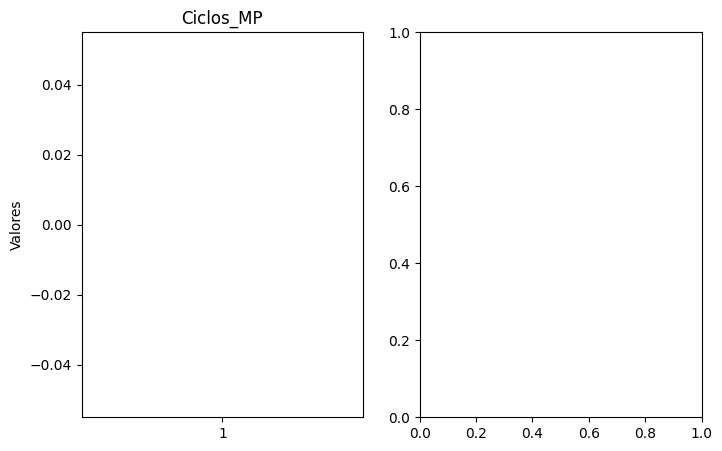

In [530]:
# Cria uma grafico para os parameros da segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_segunda_etapa):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [ ]:
# Seus arrays de tempos e severidade
Tempos = [
   [[94, 181, 358]],
[[96, 193, 374]],
[[91, 175, 327]],
[[84, 172, 348]],
[[74, 240, 426]],
[[59, 185, 365]],
[[69, 177, 368]],
[[71, 181, 380]],
[[64, 147, 342]],
[[46, 177, 375]],
]

severidade = [
   [[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
]

# Verifique se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Index;Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [ ]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

In [ ]:
dados.info()

In [ ]:
dados.describe()